In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import itertools
import cv2, PIL
import os, glob
import csv, platform

current_os = platform.system()
if current_os == "Linux":
    _path = '/home/kji/workspace/jupyter_kji/samsumg_sem_dataset'
    cfg = {
        'device': "cuda:5",
        "db_path": _path,
        'epochs': 50,
        'batch_size': 64,
        'lr': 0.0002,
        'num_workers': 4,
        'n_fold': 5
    }
elif current_os == "Windows":
    _path = 'D:/git_repos/samsung_sem'
    cfg = {
        'device': "cuda:0",
        "db_path": _path,
        'epochs': 100,
        'batch_size': 4,
        'lr': 0.0002,
        'num_workers': 0,
        'n_fold': 5
    }

import wandb

project_name = "221227_Samsung_sem"

# Cycle Gan Model,  Generator:Resnet, Discriminator:PatchGan

In [9]:
class resnet_block(nn.Module):
    def __init__(self, dim):
        super(resnet_block, self).__init__()

        _resnet_block = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            nn.BatchNorm2d(dim)
        ]

        self.layer = nn.Sequential(*_resnet_block)

    def forward(self, x):
        out = self.layer(x) + x
        return out

class ResnetGenerator(nn.Module):
    def __init__(self, input_ch):
        super(ResnetGenerator, self).__init__()

        self.init_layer = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_ch, 16, kernel_size=7, padding=0, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True))

        self.donw_sampling_layer1 = nn.Sequential(
            # down sampling
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
        )

        self.donw_sampling_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True))

        self.res_block = nn.Sequential(*[resnet_block(64) for i in range(3)])

        self.up_samplig_layer1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
        )

        self.up_samplig_layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.output_layer = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(16, input_ch, kernel_size=7, padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        # x = self.model(x)
        out1 = self.init_layer(x)
        out2 = self.donw_sampling_layer1(out1)
        out3 = self.donw_sampling_layer2(out2)
        out4 = self.res_block(out3)
        out5 = self.up_samplig_layer1(out4)
        out6 = self.up_samplig_layer2(out5)
        out7 = self.output_layer(out6)
        return out7

    def set_requires_grad(self, mode):
        for param in self.parameters():
            param.requires_grad = mode

class PatchGanDiscriminator(nn.Module):
    def __init__(self, input_ch):
        super(PatchGanDiscriminator, self).__init__()

        model = [
            nn.Conv2d(input_ch, 16, kernel_size=7, stride=1, padding=1, padding_mode='replicate'),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, True),
            nn.Dropout(p=0.2),

            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=True),  # 1
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, True),
            nn.Dropout(p=0.2),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=True),  # 2
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),
            nn.Dropout(p=0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            nn.Dropout(p=0.2),

            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=1)
        ]

        self.model = nn.Sequential(*model)

    def set_requires_grad(self, mode):
        for param in self.parameters():
            param.requires_grad = mode

    def forward(self, x):
        return self.model(x)

class GANLoss(nn.Module):
    def __init__(self, gan_mode):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(1.0))
        self.register_buffer('fake_label', torch.tensor(0.0))
        self.gan_mode = gan_mode

        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'wgan_gp':
            self.loss = None

    def __call__(self, prediction, target_is_real):
        if self.gan_mode == 'lsgan':
            if target_is_real:
                target_tensor = self.real_label  # .to(self.device)
            else:
                target_tensor = self.fake_label  # .to(self.device)

            target_tensor = target_tensor.expand_as(prediction)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgan_gp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss

def _gradient_penalty(netD, real_data, fake_data, type="mixed", constant=1.0, lambda_gp=10.0):
    if lambda_gp > 0.0:
        if type == 'real':  # either use real images, fake images, or a linear interpolation of two.
            interpolatesv = real_data
        elif type == 'fake':
            interpolatesv = fake_data
        elif type == 'mixed':
            alpha = torch.rand(real_data.shape[0], 1, device=real_data.device)
            alpha = alpha.expand(real_data.shape[0], real_data.nelement() // real_data.shape[0]).contiguous().view(
                *real_data.shape)
            interpolatesv = alpha * real_data + ((1 - alpha) * fake_data)
        else:
            raise NotImplementedError('{} not implemented'.format(type))
        interpolatesv.requires_grad_(True)
        disc_interpolates = netD(interpolatesv)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolatesv,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(real_data.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)
        gradients = gradients[0].view(real_data.size(0), -1)  # flat the data
        gradient_penalty = (((gradients + 1e-16).norm(2, dim=1) - constant) ** 2).mean() * lambda_gp  # added eps
        return gradient_penalty, gradients
    else:
        return 0.0, None

class cycleGAN_model(nn.Module):
    def __init__(self, input_ch=3,
                 optim_lr=0.0002,
                 gan_mode='lsgan',
                 guided=False):
        import itertools

        super(cycleGAN_model, self).__init__()
        self.gan_mode = gan_mode
        self.guided = guided

        self.Gen = nn.ModuleDict({
            'A': ResnetGenerator(input_ch),
            'B': ResnetGenerator(input_ch)
        })

        # wandb.watch(self.Gen['A'], log='all')
        # wandb.watch(self.Gen['B'], log='all')

        self.Dis = nn.ModuleDict({
            'A': PatchGanDiscriminator(input_ch),
            'B': PatchGanDiscriminator(input_ch)
        })

        # wandb.watch(self.Dis['A'], log='all')
        # wandb.watch(self.Dis['B'], log='all')

        self.optimizer = {
            'G': torch.optim.Adam(itertools.chain(self.Gen['A'].parameters(), self.Gen['B'].parameters()), lr=optim_lr,
                                  betas=(0.5, 0.999)),
            'D_A': torch.optim.Adam(self.Dis['A'].parameters(), lr=optim_lr,
                                  betas=(0.5, 0.999)),
            'D_B': torch.optim.Adam(self.Dis['B'].parameters(), lr=optim_lr,
                                  betas=(0.5, 0.999))
        }

        self.schedular = {
            'G': torch.optim.lr_scheduler.LambdaLR(self.optimizer['G'], lr_lambda=lambda epoch: 0.95 ** epoch),
            'D_A': torch.optim.lr_scheduler.LambdaLR(self.optimizer['D_A'], lr_lambda=lambda epoch: 0.95 ** epoch),
            'D_B': torch.optim.lr_scheduler.LambdaLR(self.optimizer['D_B'], lr_lambda=lambda epoch: 0.95 ** epoch)
        }

        self.criterion = nn.ModuleDict({
            'cycle': nn.L1Loss(),
            'idt': nn.L1Loss(),
            'gan': GANLoss(self.gan_mode),
            'mse': nn.MSELoss(),
            'guided': nn.L1Loss()
        })

        self.lambda_idt = 0.5
        self.lambda_A = 10.0
        self.lambda_B = 10.0

    def forward(self, data_A, data_B, mode: str):
        if mode == 'gen':
            A_out = self.Gen['A'](data_A)
            B_out = self.Gen['B'](data_B)
        elif mode == 'dis':
            A_out = self.Dis['A'](data_A)
            B_out = self.Dis['B'](data_B)
        else:
            raise None
        return A_out, B_out

    def model_train_discriminator(self, real_A, real_B):
        self.train()

        fake_B, fake_A = self(real_A, real_B, 'gen')

        self.set_requires_grad('dis', True)

        self.optimizer['D_B'].zero_grad()

        pred_real_B, pred_real_A = self(real_B, real_A, 'dis')  # netA netB
        pred_fake_B, pred_fake_A = self(fake_B.detach(), fake_A.detach(), 'dis')

        # Discriminator B update
        loss_D_B_Real = self.criterion['gan'](pred_real_A, True)
        loss_D_B_fake = self.criterion['gan'](pred_fake_A, False)

        if self.gan_mode == 'lsgan':
            loss_D_B = (loss_D_B_fake + loss_D_B_Real) * 0.5
        elif self.gan_mode == 'wgan_gp':
            gradient_penalty_B = _gradient_penalty(self.Dis['B'], real_A, fake_A.detach())
            loss_D_B = loss_D_B_fake + loss_D_B_Real + gradient_penalty_B[0]

        loss_D_B.backward()
        self.optimizer['D_B'].step()

        # Discriminator A update
        self.optimizer['D_A'].zero_grad()

        loss_D_A_Real = self.criterion['gan'](pred_real_B, True)
        loss_D_A_fake = self.criterion['gan'](pred_fake_B, False)

        if self.gan_mode == 'lsgan':
            loss_D_A = (loss_D_A_Real + loss_D_A_fake) * 0.5
        elif self.gan_mode == 'wgan_gp':
            gradient_penalty_A = _gradient_penalty(self.Dis['A'], real_B, fake_B.detach())
            loss_D_A = loss_D_A_Real + loss_D_A_fake + gradient_penalty_A[0]

        loss_D_A.backward()
        self.optimizer['D_A'].step()

        loss_dic = {'dis_a': loss_D_A.item(),
                    'dis_b': loss_D_B.item()}

        return loss_dic

    def model_train_generator(self, real_A, real_B):
        self.train()

        fake_B, fake_A = self(real_A, real_B, 'gen')
        rec_B, rec_A = self(fake_A, fake_B, 'gen')

        self.set_requires_grad('dis', False)
        self.optimizer['G'].zero_grad()

        idt_A, idt_B = self(real_B, real_A, 'gen')

        loss_idt_A = self.criterion['idt'](idt_A, real_B) * self.lambda_B * self.lambda_idt
        loss_idt_B = self.criterion['idt'](idt_B, real_A) * self.lambda_A * self.lambda_idt

        dis_A_fake_B, dis_B_fake_A = self(fake_B, fake_A, 'dis')  # dis_A(fake_B) / dis_B(fake_A)

        loss_G_A = self.criterion['gan'](dis_A_fake_B, True)
        loss_G_B = self.criterion['gan'](dis_B_fake_A, True)

        loss_cycle_A = self.criterion['cycle'](rec_A, real_A) * self.lambda_A
        loss_cycle_B = self.criterion['cycle'](rec_B, real_B) * self.lambda_B

        # Guied Loss (paired)
        if self.guided:
            loss_guided_A = self.criterion['guided'](fake_B, real_B)
            loss_guided_B = self.criterion['guided'](fake_A, real_A)
        else:
            loss_guided_A = 0
            loss_guided_B = 0
        ##########

        loss_Gen = loss_G_A + loss_G_B + loss_cycle_A + loss_cycle_B + loss_idt_A + loss_idt_B + loss_guided_A + loss_guided_B
        loss_Gen.backward()

        self.optimizer['G'].step()

        loss_dic = {'gen': loss_Gen.item()}

        inference_image = {
            'real_a': real_A,
            'real_b': real_B,
            'atob_fake': fake_B,
            'btoa_fake': fake_A,
            'rec_a': rec_A,
            'rec_b': rec_B
        }

        return loss_dic, {key: self.tensortonp(inference_image[key]) for key in inference_image}

    def model_valid(self, real_A, real_B):
        self.eval()

        with torch.no_grad():
            fake_B, fake_A = self(real_A, real_B, 'gen')

            true = (real_B * 255).type(torch.uint8).float()
            fake_true = (fake_B * 255).type(torch.uint8).float()
            rmse_loss = torch.sqrt(self.criterion['mse'](fake_true, true))

        img_dict = {
            'real_A': real_A,
            'fake_B': fake_B,

            'real_B': real_B,
            'fake_A': fake_A,
        }

        return rmse_loss.item(), {key: self.tensortonp(img_dict[key]) for key in img_dict}

    def tensortonp(self, tensor):
        return (tensor.detach().cpu().numpy() * 255).astype(np.uint8)

    def set_requires_grad(self, net_type='dis', mode=True):
        if net_type == 'gen':
            net_dic = self.Gen
        elif net_type == 'dis':
            net_dic = self.Dis

        for key in net_dic:
            net_dic[key].set_requires_grad(mode)

    def schedular_step(self):
        self.schedular['G'].step()
        self.schedular['D_A'].step()
        self.schedular['D_B'].step()

    def model_save(self, PATH):
        temp_dict = {}
        key_list = [key for key in self.__dict__.keys() if not '_' in key[0]]
        key_list.extend([key for key in self.__dict__['_modules'].keys()])

        for key in key_list:
            if hasattr(self, key):
                value = getattr(self, key)
                if isinstance(value, dict):
                    if not key in temp_dict:
                        temp_dict[key] = {}
                    for sub_key in value.keys():
                        if not sub_key in temp_dict[key]:
                            temp_dict[key][sub_key] = value[sub_key].state_dict()
                elif isinstance(value, nn.ModuleDict):
                    if not key in temp_dict:
                        temp_dict[key] = value.state_dict()
                else:
                    if not key in temp_dict:
                        temp_dict[key] = value

        torch.save(temp_dict, PATH)

    def model_load(self, PATH, device):
        state_dict = torch.load(PATH, map_location=device)

        for cls_key in state_dict.keys():
            if hasattr(self, cls_key):
                value = getattr(self, cls_key)
                if isinstance(value, dict):
                    for sub_key in value.keys():
                        value[sub_key].load_state_dict(state_dict[cls_key][sub_key])
                elif isinstance(value, nn.ModuleDict):
                    value.load_state_dict(state_dict[cls_key])
                else:
                    setattr(self, cls_key, state_dict[cls_key])

# Dataset & Dataloader

In [3]:
def get_img_list(abs_path):
    # abs_path = '/home/kji/workspace/jupyter_kji/samsumg_sem_dataset'

    # Dataset path
    sim_depth_path = os.path.join(abs_path, 'simulation_data/Depth')
    sim_sem_path = os.path.join(abs_path, 'simulation_data/SEM')

    train_path = os.path.join(abs_path, 'train')

    # only Test
    test_path = os.path.join(abs_path, 'test/SEM')

    sim_depth_img_path_dic = dict()
    for case in os.listdir(sim_depth_path):
        if not case in sim_depth_img_path_dic:
            sim_depth_img_path_dic[case] = []
        for folder in os.listdir(os.path.join(sim_depth_path, case)):
            img_list = glob.glob(os.path.join(sim_depth_path, case, folder, '*.png'))
            for img in img_list:
                sim_depth_img_path_dic[case].append(img)
                sim_depth_img_path_dic[case].append(img)

    sim_sem_img_path_dic = dict()
    for case in os.listdir(sim_sem_path):
        if not case in sim_sem_img_path_dic:
            sim_sem_img_path_dic[case] = []
        for folder in os.listdir(os.path.join(sim_sem_path, case)):
            img_list = glob.glob(os.path.join(sim_sem_path, case, folder, '*.png'))
            sim_sem_img_path_dic[case].extend(img_list)

    train_avg_depth = dict()
    with open(os.path.join(train_path, "average_depth.csv"), 'r') as csvfile:
        temp = csv.reader(csvfile)
        for idx, line in enumerate(temp):
            if idx > 0:
                depth_key, site_key = line[0].split('_site')
                depth_key = depth_key.replace("d", "D")
                site_key = "site" + site_key
                if not depth_key in train_avg_depth:
                    train_avg_depth[depth_key] = dict()

                train_avg_depth[depth_key][site_key] = float(line[1])

    train_img_path_dic = dict()
    for depth in os.listdir(os.path.join(train_path, "SEM")):
        if not depth in train_img_path_dic:
            train_img_path_dic[depth] = []
        for site in os.listdir(os.path.join(train_path, "SEM", depth)):
            img_list = glob.glob(os.path.join(train_path, "SEM", depth, site, "*.png"))
            train_img_path_dic[depth].extend([[temp_img, train_avg_depth[depth][site]] for temp_img in img_list])

    test_img_path_list = glob.glob(os.path.join(test_path, "*.png"))

    result_dic = dict()
    result_dic['sim'] = dict()
    result_dic['sim']['sem'] = sim_sem_img_path_dic
    result_dic['sim']['depth'] = sim_depth_img_path_dic
    result_dic['train'] = train_img_path_dic
    result_dic['test'] = np.array(test_img_path_list)
    result_dic['train_avg_depth'] = train_avg_depth

    return result_dic

result_dic = get_img_list(cfg['db_path'])

'''
train sem ->  sim sem -> sim depth

case 별로 dataset을 나눠야됨.
'''

class gan_dataset(Dataset):
    def __init__(self, a_data_path, b_data_path, transform=None):
        super(gan_dataset, self).__init__()
        self.a_data_path = a_data_path
        self.b_data_path = b_data_path
        self.transform = transform

        self.a_size = len(a_data_path)
        self.b_size = len(b_data_path)

    def __getitem__(self, idx):
        if self.a_size > self.b_size:
            a_idx = idx
            b_idx = idx % self.b_size
        else:
            a_idx = idx % self.a_size
            b_idx = idx
        if isinstance(self.a_data_path[a_idx], str):
            a_path = self.a_data_path[a_idx]
        elif isinstance(self.a_data_path[a_idx], list):
            a_path = self.a_data_path[a_idx][0]

        if isinstance(self.b_data_path[b_idx], str):
            b_path = self.b_data_path[b_idx]
        elif isinstance(self.b_data_path[b_idx], list):
            b_path = self.b_data_path[b_idx][0]

        a_img = PIL.Image.open(a_path).convert("L")
        b_img = PIL.Image.open(b_path).convert("L")

        if self.transform:
            a_img = self.transform(a_img)
            b_img = self.transform(b_img)

        a_img = (np.array(a_img) / 255.)
        a_img = a_img.reshape(1, *a_img.shape).astype(np.float32)
        b_img = (np.array(b_img) / 255.)
        b_img = b_img.reshape(1, *b_img.shape).astype(np.float32)

        return a_img, b_img

    def __len__(self):
        return max(len(self.a_data_path), len(self.b_data_path))

def create_dataloader(a_key, b_key, t_ratio, result_dic, case=1):
    if 'sim' in a_key:
        a_list = result_dic['sim'][a_key.split('_')[-1]][f"Case_{case}"]
    else:
        a_list = result_dic['train'][f"Depth_{100 + 10 * case}"]
    if 'sim' in b_key:
        b_list = result_dic['sim'][b_key.split('_')[-1]][f"Case_{case}"]
    else:
        b_list = result_dic['train'][f"Depth_{100 + 10 * case}"]

    horizon_transform = transforms.RandomHorizontalFlip(1.0)
    rotate_transform = transforms.RandomRotation((180, 180))
    vertical_transform = transforms.RandomVerticalFlip(1.0)

    a_train_data_size = int(len(a_list) * t_ratio)
    b_train_data_size = int(len(b_list) * t_ratio)

    train_dataset = gan_dataset(a_list[:a_train_data_size], b_list[:b_train_data_size], None) + \
                    gan_dataset(a_list[:a_train_data_size], b_list[:b_train_data_size], horizon_transform) + \
                    gan_dataset(a_list[:a_train_data_size], b_list[:b_train_data_size], rotate_transform) + \
                    gan_dataset(a_list[:a_train_data_size], b_list[:b_train_data_size], vertical_transform)

    valid_dataset = gan_dataset(a_list[a_train_data_size:], b_list[b_train_data_size:], None) + \
                    gan_dataset(a_list[a_train_data_size:], b_list[b_train_data_size:], horizon_transform) + \
                    gan_dataset(a_list[a_train_data_size:], b_list[b_train_data_size:], rotate_transform) + \
                    gan_dataset(a_list[a_train_data_size:], b_list[b_train_data_size:], vertical_transform)

    return DataLoader(train_dataset, batch_size=cfg['batch_size'], num_workers=cfg['num_workers'], shuffle=True), \
           DataLoader(valid_dataset, batch_size=cfg['batch_size'], num_workers=cfg['num_workers'], shuffle=False)

# Training Code

In [4]:
import matplotlib.pyplot as plt

def valid(model, valid_dataloader, device):
    rmse_list = []
    img_mean_list = []
    for step_i, data_tuple in enumerate(valid_dataloader):
        real_a = data_tuple[0].to(device, non_blocking=True)
        real_b = data_tuple[1].to(device, non_blocking=True)

        rmse_loss, img_dict = model.model_valid(real_a, real_b)
        rmse_list.append(rmse_loss)
        if step_i == 0:
            img_list = [img_dict[key][0][0] for key in img_dict]
            img_list = [wandb.Image(PIL.Image.fromarray(np.concatenate((img_list[i], img_list[i+1]), axis=-1)).convert('L'), caption=key)
                        for i, key in enumerate(img_dict.keys()) if i % 2 == 0]
            wandb.log({
                "example image": img_list
            })
        
    
        img_mean_list.extend(list(np.mean(img_dict['fake_B'], axis=(1,2,3))))
        
    fig = plt.figure(figsize=(8, 5))
    
    plt.hist(img_mean_list, bins=100, density=True, alpha=0.5, color=plt.cm.tab20c(1))
    plt.xlim(80, 200)
    plt.tight_layout()
    
    wandb.log({
        'plot': wandb.Image(fig)
    })
    
    plt.clf()
    plt.cla()
    plt.close()
    
    return np.mean(rmse_list)

def training(case, epochs, device, type, guided ,checkpoint_path=None):
    best_rmse_loss = 9999
    critic_iter = 5
    best_epoch = 0

    if type == 'semtodepth':
        a_key = 'sim_sem'
        b_key = 'sim_depth'
    elif type == 'simtotrain':
        a_key = 'sim_sem'
        b_key = 'train'

    train_dataloader, valid_dataloader = create_dataloader(a_key=a_key,
                                                           b_key=b_key,
                                                           t_ratio=0.8,
                                                           result_dic=result_dic,
                                                           case=case)

    model = cycleGAN_model(1, optim_lr=0.0002, gan_mode='wgan_gp', guided=guided)

    if checkpoint_path:
        model.model_load(checkpoint_path, device)

    model.to(device)

    for epoch in range(epochs):
        loss_list = [[], [], []]
        for step_i, data_tuple in enumerate(train_dataloader):
            real_a = data_tuple[0].to(device, non_blocking=True)
            real_b = data_tuple[1].to(device, non_blocking=True)

            dis_loss = model.model_train_discriminator(real_a, real_b)
            loss_list[1].append(dis_loss['dis_a'])
            loss_list[2].append(dis_loss['dis_b'])
            if step_i % critic_iter == 0:
                gen_loss, img_dic = model.model_train_generator(real_a, real_b)
                loss_list[0].append(gen_loss['gen'])

                wandb.log({
                    'Gen_step_loss': gen_loss,
                    'Dis_A_step_loss': dis_loss['dis_a'],
                    'Dis_B_step_loss': dis_loss['dis_b']
                })

            
        rmse_loss = valid(model, valid_dataloader, device)
        print(f'epoch - {epoch}, gen loss - {gen_loss}, rmse loss - {rmse_loss}')
        wandb.log({
            'Gen_loss': np.mean(loss_list[0]),
            'Dis_A_loss': np.mean(loss_list[1]),
            'Dis_B_loss': np.mean(loss_list[2]),
            'learning_rate': model.schedular['G'].get_last_lr(),
            'rmse_loss': rmse_loss
        })

        if best_rmse_loss > rmse_loss:
            best_rmse_loss = rmse_loss
            model.model_save(f'./case{case}_t({type})_best_model.pth')

        model.schedular_step()
    print(f'training end, best epoch - {best_epoch}, best valid rmse loss - {best_rmse_loss}')

# Simulation Sem to Simulation Depth Case #1 training 
## Add Guided L1 Loss

In [5]:
wandb.init(project=project_name, entity="kimjiil2013", name="semtodepth_c1")
training(1, cfg['epochs'], cfg['device'], 'semtodepth', True)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kimjiil2013. Use `wandb login --relogin` to force relogin


epoch - 0, gen loss - {'gen': 1.0379643440246582}, rmse loss - 9.922977866281883
epoch - 1, gen loss - {'gen': 0.9865840077400208}, rmse loss - 9.445224395977174
epoch - 2, gen loss - {'gen': 1.0307201147079468}, rmse loss - 9.19954258049546
epoch - 3, gen loss - {'gen': 1.164305567741394}, rmse loss - 8.986725249413634
epoch - 4, gen loss - {'gen': 1.1354504823684692}, rmse loss - 8.811310095100826
epoch - 5, gen loss - {'gen': 1.0747076272964478}, rmse loss - 8.55147104157733
epoch - 6, gen loss - {'gen': 1.1227301359176636}, rmse loss - 8.443565941384797
epoch - 7, gen loss - {'gen': 1.0541313886642456}, rmse loss - 8.260078565660878
epoch - 8, gen loss - {'gen': 0.9875705242156982}, rmse loss - 8.138526282187318
epoch - 9, gen loss - {'gen': 1.1196106672286987}, rmse loss - 8.056576046996451
epoch - 10, gen loss - {'gen': 1.0708122253417969}, rmse loss - 8.057947494886898
epoch - 11, gen loss - {'gen': 0.8867712616920471}, rmse loss - 7.771504817413668
epoch - 12, gen loss - {'gen'

Dis_A_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_A_step_loss,▅▂▄▄▆▄█▆▆▅▅▆▆▂▅▃▃▆▅▁▄▆▄▂▅▃▅▂▃▄▂▅▆▄▁▃▂▄▁▅
Dis_B_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_B_step_loss,▇▆▅▄▅▁▆█▅▆▆▆▆▅▆▆▆▇▅▆▇▅▆▆▇▆▆▆▆▅▆▆▆▇▆▅▆▅▄▅
Gen_loss,█▅▅▅▆▅▅▅▅▄▄▄▄▄▃▃▂▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
rmse_loss,█▇▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_A_loss,-0.00441
Dis_A_step_loss,0.01081
Dis_B_loss,-0.00395
Dis_B_step_loss,0.00217
Gen_loss,0.48799


# Simulation Sem to Simulation Depth Case #2 training 
## Add Guided L1 Loss

In [6]:
wandb.init(project=project_name, entity="kimjiil2013", name="semtodepth_c2")
training(2, cfg['epochs'], cfg['device'], 'semtodepth', True)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kimjiil2013. Use `wandb login --relogin` to force relogin


epoch - 0, gen loss - {'gen': 1.129433512687683}, rmse loss - 11.936002984697968
epoch - 1, gen loss - {'gen': 1.0094826221466064}, rmse loss - 10.69811074408218
epoch - 2, gen loss - {'gen': 0.9620792865753174}, rmse loss - 10.258456048930263
epoch - 3, gen loss - {'gen': 0.7936031222343445}, rmse loss - 10.296285560650139
epoch - 4, gen loss - {'gen': 0.7312467694282532}, rmse loss - 9.969710321883873
epoch - 5, gen loss - {'gen': 0.7555220127105713}, rmse loss - 9.559059364769292
epoch - 6, gen loss - {'gen': 0.6315388083457947}, rmse loss - 9.517359174045689
epoch - 7, gen loss - {'gen': 0.6281772255897522}, rmse loss - 9.214861857495185
epoch - 8, gen loss - {'gen': 0.7077594995498657}, rmse loss - 9.102339892369795
epoch - 9, gen loss - {'gen': 0.5027087926864624}, rmse loss - 9.086325851313742
epoch - 10, gen loss - {'gen': 0.6986837387084961}, rmse loss - 8.92689421520022
epoch - 11, gen loss - {'gen': 0.6494389176368713}, rmse loss - 8.915030256848494
epoch - 12, gen loss - {'

Dis_A_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_A_step_loss,▆▄▇▃█▄▅▁▃▃▅▅▃▂▄▁▆▄▂▃▅▃▃▅▄▂▅▃▃▂▃▆▂▅▃▆▆▅▅▁
Dis_B_loss,█▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Dis_B_step_loss,▇▆▅▁▁▄▆▆▆▇▆▆▅▆▇▆▆▇▇▆▇▇▆▇▇▆▅▆▆▆▆▅▆▅▇▇▆▇█▆
Gen_loss,█▅▅▄▃▃▃▃▂▃▃▃▂▂▂▃▂▁▁▁▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁
rmse_loss,█▅▄▅▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_A_loss,-0.0046
Dis_A_step_loss,-0.00501
Dis_B_loss,-0.00548
Dis_B_step_loss,-0.01851
Gen_loss,0.34842


# Simulation Sem to Simulation Depth Case #3 training 
## Add Guided L1 Loss

In [7]:
wandb.init(project=project_name, entity="kimjiil2013", name="semtodepth_c3")
training(3, cfg['epochs'], cfg['device'], 'semtodepth', True)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kimjiil2013. Use `wandb login --relogin` to force relogin


epoch - 0, gen loss - {'gen': 0.8269416093826294}, rmse loss - 11.945897679487278
epoch - 1, gen loss - {'gen': 0.7820778489112854}, rmse loss - 11.519457561943364
epoch - 2, gen loss - {'gen': 0.9086331129074097}, rmse loss - 10.81839163804846
epoch - 3, gen loss - {'gen': 0.8253433108329773}, rmse loss - 10.592001337846707
epoch - 4, gen loss - {'gen': 0.9413123726844788}, rmse loss - 10.362369030604063
epoch - 5, gen loss - {'gen': 1.0336304903030396}, rmse loss - 10.414705600245853
epoch - 6, gen loss - {'gen': 0.9275076985359192}, rmse loss - 10.137042550583168
epoch - 7, gen loss - {'gen': 0.8957818746566772}, rmse loss - 9.717079157319017
epoch - 8, gen loss - {'gen': 0.9087523818016052}, rmse loss - 9.55042094762035
epoch - 9, gen loss - {'gen': 0.96787029504776}, rmse loss - 9.773470322584314
epoch - 10, gen loss - {'gen': 0.8811497688293457}, rmse loss - 9.417069206378557
epoch - 11, gen loss - {'gen': 1.0183578729629517}, rmse loss - 9.498465163241454
epoch - 12, gen loss - 

Dis_A_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_A_step_loss,█▅▆▆▅█▇█▇▆▅▅▄▆▇▅▇▂█▄▆▂▅▄▆▇▆▅▄▃▄▅▁█▄▅▆▆▅▅
Dis_B_loss,█▂▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Dis_B_step_loss,▆▇▇▄▁▁▇▆▇▇▇▇▇█▇█▇▇▇█▆▆▇▆▆▇██▇▇▇▇▇▆▆▇▇▆█▇
Gen_loss,█▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▂▂▂▂▃▃▂▁▁▁▂▁▁▁▂▂▁▁▂▁▁▂
rmse_loss,█▇▅▄▄▃▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▂▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂
Dis_A_loss,-0.00513
Dis_A_step_loss,-0.01805
Dis_B_loss,-0.00417
Dis_B_step_loss,-0.0046
Gen_loss,0.62848


# Simulation Sem to Simulation Depth Case #4 training 
## Add Guided L1 Loss

In [8]:
wandb.init(project=project_name, entity="kimjiil2013", name="semtodepth_c4")
training(4, cfg['epochs'], cfg['device'], 'semtodepth', True)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kimjiil2013. Use `wandb login --relogin` to force relogin


epoch - 0, gen loss - {'gen': 0.6604704260826111}, rmse loss - 14.101684195529051
epoch - 1, gen loss - {'gen': 0.6534086465835571}, rmse loss - 12.544267869083644
epoch - 2, gen loss - {'gen': 0.6616231203079224}, rmse loss - 12.251521453646276
epoch - 3, gen loss - {'gen': 0.6316924691200256}, rmse loss - 12.500395120289932
epoch - 4, gen loss - {'gen': 0.6813871264457703}, rmse loss - 11.685922700100718
epoch - 5, gen loss - {'gen': 0.6801038384437561}, rmse loss - 11.540210567277295
epoch - 6, gen loss - {'gen': 0.885643720626831}, rmse loss - 10.980432211253037
epoch - 7, gen loss - {'gen': 0.7650645971298218}, rmse loss - 10.950064016884104
epoch - 8, gen loss - {'gen': 0.9081915020942688}, rmse loss - 10.707524371762997
epoch - 9, gen loss - {'gen': 0.7454079985618591}, rmse loss - 10.502712001659773
epoch - 10, gen loss - {'gen': 0.9378820657730103}, rmse loss - 10.646602352606854
epoch - 11, gen loss - {'gen': 0.898623526096344}, rmse loss - 10.516715310156565
epoch - 12, gen 

Dis_A_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_A_step_loss,▂▇▂▄▇▁▄▃█▂▂▂▅▃▃▆▃▁▄▃▆▂▄▅▅▃▂▅▄▆▄▃▂▃▆▄▄▅▁▂
Dis_B_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_B_step_loss,█▆▅▅▃▁▃▅▇▅▆▇▇▅▆▆█▆▆▅▆▇▆▅▆▆▆▇▆█▇▇▆▆▅▆▆▆▆▇
Gen_loss,█▃▃▃▃▄▄▅▅▅▄▄▄▄▄▄▃▄▄▃▂▂▂▂▂▂▂▂▁▁▁▂▁▂▂▂▂▁▁▂
rmse_loss,█▅▄▅▃▂▂▁▁▁▂▂▁▂▁▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Dis_A_loss,-0.00535
Dis_A_step_loss,-0.01099
Dis_B_loss,-0.00454
Dis_B_step_loss,-0.0027
Gen_loss,0.44567


# Simulation Sem to Train Sem Case #1 training 


In [9]:
wandb.init(project=project_name, entity="kimjiil2013", name="simtotrain_c1")
training(1, cfg['epochs'], cfg['device'], 'simtotrain', False)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kimjiil2013. Use `wandb login --relogin` to force relogin


epoch - 0, gen loss - {'gen': 0.749372124671936}, rmse loss - 15.811355872347786
epoch - 1, gen loss - {'gen': 0.6989802122116089}, rmse loss - 15.31605438464682
epoch - 2, gen loss - {'gen': 0.7218635082244873}, rmse loss - 15.507768078483778
epoch - 3, gen loss - {'gen': 0.5630615949630737}, rmse loss - 14.839394440950063
epoch - 4, gen loss - {'gen': 0.6045677661895752}, rmse loss - 15.071120026366737
epoch - 5, gen loss - {'gen': 0.6629830598831177}, rmse loss - 15.0545671399669
epoch - 6, gen loss - {'gen': 0.590895414352417}, rmse loss - 14.70248695669139
epoch - 7, gen loss - {'gen': 0.5510333180427551}, rmse loss - 14.766395415767093
epoch - 8, gen loss - {'gen': 0.5571500062942505}, rmse loss - 14.699557522566117
epoch - 9, gen loss - {'gen': 0.5645549893379211}, rmse loss - 14.764706067933368
epoch - 10, gen loss - {'gen': 0.5596492290496826}, rmse loss - 15.017865675401863
epoch - 11, gen loss - {'gen': 0.5395370125770569}, rmse loss - 14.82194019507658
epoch - 12, gen loss 

Dis_A_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_A_step_loss,█▆▅▅▄▄▄▄▆▄▃▃▄▃▅▃▂▂█▅▃▃▂▃▁▅▂▅▅▅▅▃▃▄▂▃▂▃▂▄
Dis_B_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_B_step_loss,▆█▆▁▁▃▄▄▅▂▅▂▆▄▄▆▄▄▆▆▅▅▅▄▅▄▅▅▅▅▅▆▆▅▄▄▄▆▅▆
Gen_loss,█▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rmse_loss,█▅▆▂▃▁▁▁▃▂▂▃▂▂▃▃▃▄▄▃▃▄▃▃▃▃▃▄▄▃▃▄▄▃▃▃▃▃▃▃
Dis_A_loss,-0.0156
Dis_A_step_loss,-0.01445
Dis_B_loss,-0.01106
Dis_B_step_loss,-0.01438
Gen_loss,0.18935


# Simulation Sem to Train Sem Case #2 training 


In [10]:
wandb.init(project=project_name, entity="kimjiil2013", name="simtotrain_c2")
training(2, cfg['epochs'], cfg['device'], 'simtotrain', False)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kimjiil2013. Use `wandb login --relogin` to force relogin


epoch - 0, gen loss - {'gen': 0.8475733995437622}, rmse loss - 16.544937251678693
epoch - 1, gen loss - {'gen': 0.873705267906189}, rmse loss - 16.31470018647254
epoch - 2, gen loss - {'gen': 0.9549434185028076}, rmse loss - 16.375406379629325
epoch - 3, gen loss - {'gen': 0.8656570315361023}, rmse loss - 16.41269726946785
epoch - 4, gen loss - {'gen': 0.7125281095504761}, rmse loss - 15.269447402320665
epoch - 5, gen loss - {'gen': 0.609251856803894}, rmse loss - 15.164793614531796
epoch - 6, gen loss - {'gen': 0.6530883312225342}, rmse loss - 14.655090168393405
epoch - 7, gen loss - {'gen': 0.591376543045044}, rmse loss - 14.433143455603906
epoch - 8, gen loss - {'gen': 0.5347281694412231}, rmse loss - 14.369638400764043
epoch - 9, gen loss - {'gen': 0.4520851671695709}, rmse loss - 14.129558561472875
epoch - 10, gen loss - {'gen': 0.48283660411834717}, rmse loss - 13.96830759013271
epoch - 11, gen loss - {'gen': 0.5279279947280884}, rmse loss - 13.871883376498063
epoch - 12, gen los

Dis_A_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_A_step_loss,█▄▁▆▂▅▅▆▃▆▅▅▇▅▅▄▇▂▄▅▇▅▄▅▅▄▅▆▄▅█▄▆▄▅▄▄▆▃▅
Dis_B_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_B_step_loss,▇▆▇▅▃▂▁▃█▇▆▆▆▆▇▅▆▆▇▆▅▆▇▇▆▇▇█▇▇▇▅▆▆▇▅▇▆▆▆
Gen_loss,█▄▅▅▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rmse_loss,█▇██▅▄▃▃▂▂▂▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃
Dis_A_loss,-0.00601
Dis_A_step_loss,0.00856
Dis_B_loss,-0.00981
Dis_B_step_loss,-0.00129
Gen_loss,0.34611


# Simulation Sem to Train Sem Case #3 training 


In [11]:
wandb.init(project=project_name, entity="kimjiil2013", name="simtotrain_c3")
training(3, cfg['epochs'], cfg['device'], 'simtotrain', False)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kimjiil2013. Use `wandb login --relogin` to force relogin


epoch - 0, gen loss - {'gen': 0.7993854284286499}, rmse loss - 16.955419677649918
epoch - 1, gen loss - {'gen': 0.7363439202308655}, rmse loss - 16.20881504326289
epoch - 2, gen loss - {'gen': 0.7477864623069763}, rmse loss - 16.169494326264218
epoch - 3, gen loss - {'gen': 0.8498913049697876}, rmse loss - 16.049047179767566
epoch - 4, gen loss - {'gen': 0.6017487049102783}, rmse loss - 15.561492033110333
epoch - 5, gen loss - {'gen': 0.540407657623291}, rmse loss - 15.44299863977186
epoch - 6, gen loss - {'gen': 0.5702083706855774}, rmse loss - 15.686407307417191
epoch - 7, gen loss - {'gen': 0.4010618329048157}, rmse loss - 16.40861315041011
epoch - 8, gen loss - {'gen': 0.2969590127468109}, rmse loss - 15.229439114292608
epoch - 9, gen loss - {'gen': 0.3303644061088562}, rmse loss - 14.883136615542028
epoch - 10, gen loss - {'gen': 0.23134900629520416}, rmse loss - 14.81949131427216
epoch - 11, gen loss - {'gen': 0.3446091413497925}, rmse loss - 15.070698187360025
epoch - 12, gen lo

Dis_A_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_A_step_loss,▅▂▁▅▄▅▆▄▄▇▄▃▄▄▂▅▅█▄▆▅▄▃▅▄▄▃▃▃▄▅▂▃▅▄▃▃▄▂▄
Dis_B_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_B_step_loss,█▇▇▄▃▂▁▅▂▄▆▆▆▅▇▇▆▆▆▇▇▅▆▇▅▅▅▆▅▄▇▇▇▆▆▇▆▅▅▆
Gen_loss,█▆▅▆▄▄▄▃▂▂▂▂▂▂▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▂▂▂▁▁▁▁
rmse_loss,█▆▅▅▃▄▆▂▁▂▁▁▂▁▃▄▄▄▄▄▅▅▄▅▅▅▅▅▅▆▆▆▅▅▅▅▅▅▅▅
Dis_A_loss,-0.00655
Dis_A_step_loss,-0.01271
Dis_B_loss,-0.01161
Dis_B_step_loss,-0.00589
Gen_loss,0.1496


# Simulation Sem to Train Sem Case #4 training 


In [12]:
wandb.init(project=project_name, entity="kimjiil2013", name="simtotrain_c4")
training(4, cfg['epochs'], cfg['device'], 'simtotrain', False)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kimjiil2013. Use `wandb login --relogin` to force relogin


epoch - 0, gen loss - {'gen': 0.6394338607788086}, rmse loss - 14.568509172249545
epoch - 1, gen loss - {'gen': 0.570279598236084}, rmse loss - 14.762874283033984
epoch - 2, gen loss - {'gen': 0.5614814758300781}, rmse loss - 14.92353095339673
epoch - 3, gen loss - {'gen': 0.5641460418701172}, rmse loss - 14.836537565252438
epoch - 4, gen loss - {'gen': 0.5018516778945923}, rmse loss - 15.050771956074282
epoch - 5, gen loss - {'gen': 0.6536893844604492}, rmse loss - 14.852180676266716
epoch - 6, gen loss - {'gen': 0.6067661046981812}, rmse loss - 14.672394043405118
epoch - 7, gen loss - {'gen': 0.41985756158828735}, rmse loss - 14.858069326604864
epoch - 8, gen loss - {'gen': 0.14360401034355164}, rmse loss - 14.804652662734703
epoch - 9, gen loss - {'gen': 0.15292397141456604}, rmse loss - 14.822184381449794
epoch - 10, gen loss - {'gen': 0.3205029368400574}, rmse loss - 14.711959705141638
epoch - 11, gen loss - {'gen': 0.2846326231956482}, rmse loss - 14.691237972231368
epoch - 12, g

Dis_A_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_A_step_loss,█▆▆▃▆▄▆▁▃▄▂▂▆▆▅▃▃▃▃▆▃▃▇▅▄▁▄▃▄▅▆▅▄▂▄▃▄▄▅▅
Dis_B_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Dis_B_step_loss,██▆▅▃▁▃▆▆▅▅▄▇▆█▄▂▅▅▆▄▅▄▅▆▄▆▆▇▆▅▅▆▅▆▆▆▆▄▄
Gen_loss,█▅▄▄▄▅▄▃▂▃▃▂▃▃▂▂▂▂▂▂▁▁▂▂▁▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂
rmse_loss,▁▂▃▃▃▂▃▃▂▂▃▃▂▃▄▄▆▆▅█▆▅▆▆▅▆▆▅▅▇▆▅▆▇▆▆▆▆▆▆
Dis_A_loss,-0.01058
Dis_A_step_loss,-0.02343
Dis_B_loss,-0.00822
Dis_B_step_loss,-0.00601
Gen_loss,0.05908


# Submission Dataset

In [2]:
class test_dataset(Dataset):
    def __init__(self, path_list, transforms):
        super(test_dataset, self).__init__()
        self.path_list = path_list
        self.transforms = transforms

    def __getitem__(self, idx):
        item = self.path_list[idx]
        img = None
        depth = 0
        img_name = None

        if isinstance(item, str):
            img = PIL.Image.open(item).convert("L")
            img_name = item.split('/')[-1].split('\\')[-1]
        elif isinstance(item, list):
            img = PIL.Image.open(item[0]).convert("L")
            img_name = item[0].split('/')[-1].split('\\')[-1]
            depth = item[1]

        if self.transforms:
            img = self.transforms(img)

        img = np.array(img).astype(np.float32) / 255.
        img = img.reshape(1, *img.shape)

        return img, depth, img_name

    def __len__(self):
        return len(self.path_list)


In [19]:
submission_data_path_list = glob.glob(os.path.join(cfg['db_path'], "sample_submission",  '*.png'))
submission_db = test_dataset(submission_data_path_list, None)
submission_dataloader = DataLoader(submission_db, batch_size=cfg['batch_size'], num_workers=cfg['num_workers'])

In [32]:
submission_data_path_list[:10]

['/home/kji/workspace/jupyter_kji/samsumg_sem_dataset/sample_submission/010902.png',
 '/home/kji/workspace/jupyter_kji/samsumg_sem_dataset/sample_submission/016640.png',
 '/home/kji/workspace/jupyter_kji/samsumg_sem_dataset/sample_submission/006260.png',
 '/home/kji/workspace/jupyter_kji/samsumg_sem_dataset/sample_submission/013556.png',
 '/home/kji/workspace/jupyter_kji/samsumg_sem_dataset/sample_submission/006584.png',
 '/home/kji/workspace/jupyter_kji/samsumg_sem_dataset/sample_submission/022097.png',
 '/home/kji/workspace/jupyter_kji/samsumg_sem_dataset/sample_submission/023371.png',
 '/home/kji/workspace/jupyter_kji/samsumg_sem_dataset/sample_submission/009801.png',
 '/home/kji/workspace/jupyter_kji/samsumg_sem_dataset/sample_submission/001504.png',
 '/home/kji/workspace/jupyter_kji/samsumg_sem_dataset/sample_submission/019025.png']

# CNN Classifier Model

In [7]:
class CNN_classifier(nn.Module):
    def __init__(self):
        super(CNN_classifier, self).__init__()
        mobv3s = torchvision.models.mobilenet_v3_small(pretrained=True)
        feature = [nn.Sequential(nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2,2), padding=(1,1), bias=False),
                   nn.BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
                   nn.Hardswish())]
        feature.extend([mobv3s.features._modules[module_key] for i, module_key in enumerate(mobv3s.features._modules.keys()) if i > 0])

        self.feature = nn.Sequential(*feature)
        self.avgpool = mobv3s.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(in_features=576, out_features=128, bias=True),
            nn.Hardswish(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=128, out_features=4, bias=True)
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Submission Test

In [4]:
class ganmodels(nn.Module):
    def __init__(self, device):
        super(ganmodels, self).__init__()
        self.models = nn.ModuleList([nn.ModuleDict({"semtodepth": cycleGAN_model(1),
                                                    "simtotrain": cycleGAN_model(1)}) for i in range(4)])

        for i in range(4):
            for key in self.models[i]:
                self.models[i][key].model_load(f'./case{i+1}_t({key})_best_model.pth', device)


    def forward(self, img, cls_idx):
        # Train SEN Image To Simulation SEM Image
        img = self.models[cls_idx]['simtotrain'].Gen['B'](img)
        # Simulation SEM Image to Simulation Depth Image
        img = self.models[cls_idx]['semtodepth'].Gen['A'](img)

        return img
    
def submission_test(datalodaer, device):
    cls_model = torch.load("./best_cnn_classifer.pth", map_location=device)
    cls_model.eval()

    ganmodel = ganmodels(device)
    ganmodel.to(device)
    ganmodel.eval()

    for i, item in enumerate(datalodaer):
        sem_imgs = item[0].to(device)
        depths = item[1].to(device)
        img_names = item[2]
        
        # classification SEM Image case
        pred_cls = torch.argmax(cls_model(sem_imgs), dim=1)
        
        for img, cls_idx, name in zip(sem_imgs, pred_cls, img_names):
            pred_depth = 140 + cls_idx.item() * 10
            depth_img = ganmodel(img.reshape(1, *img.shape), cls_idx)
            
            # Depth Image 후처리 과정
            depth_img_uint8 = (depth_img * 255).type(torch.uint8).detach().cpu().numpy()
            mask = (depth_img_uint8 >= (pred_depth-1)).astype(np.float)
            kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
            d_mask = cv2.morphologyEx(mask[0][0], cv2.MORPH_CLOSE, kernel).reshape(*mask.shape)
            depth_img_uint8[d_mask.astype(np.bool_)] = pred_depth

            os.makedirs('./submission_pred', exist_ok=True)
            cv2.imwrite(os.path.join('./submission_pred', name), depth_img_uint8[0][0])

In [21]:
submission_test(submission_dataloader, cfg['device'])

/tmp/ipykernel_87183/3465738284.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (depth_img_uint8 >= (pred_depth-1)).astype(np.float)


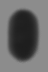

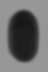

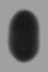

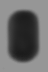

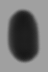

In [24]:
from IPython.display import Image, display

img_list = glob.glob('./submission_pred/*.png')[:5]

for img_path in img_list:
    display(Image(filename=img_path))

In [30]:
!pwd
!zip -r -q submission_pred.zip ./submission_pred

/home/kji/workspace/jupyter_kji


In [31]:
!ls -l | grep submission_pred

drwxrwxr-x  2 kji kji   1044480 12월 28 14:19 submission_pred
-rw-rw-r--  1 kji kji  43993228 12월 28 14:27 submission_pred.zip
